# **COMP9727 Recommender Systems**
## Assignment 25T2
### Name: Shefali Shankar
### zId: z5541347

## Part 1 - Topic Classification

In [3]:
import pandas as pd
# Load Dataset
# pd.set_option('display.width', 180)
# pd.set_option('display.max_colwidth', 140)
df_dataset = pd.read_csv('dataset.tsv', sep='\t')
df_dataset

,artist_name,track_name,release_date,genre,lyrics,topic
0,loving,the not real lake,2016,rock,awake know go see time clear world mirror worl...,dark
1,incubus,into the summer,2019,rock,shouldn summer pretty build spill ready overfl...,lifestyle
2,reignwolf,hardcore,2016,blues,lose deep catch breath think say try break wal...,sadness
3,tedeschi trucks band,anyhow,2016,blues,run bitter taste take rest feel anchor soul pl...,sadness
4,lukas nelson and promise of the real,if i started over,2017,blues,think think different set apart sober mind sym...,dark
...,...,...,...,...,...,...
1495,ra ra riot,absolutely,2016,rock,year absolutely absolutely absolutely crush ab...,emotion
1496,mat kearney,face to face,2018,rock,breakthrough hours hear truth moments trade fa...,dark
1497,owane,born in space,2018,jazz,look look right catch blue eye own state breat...,dark
1498,nappy roots,blowin' trees,2019,hip hop,nappy root gotta alright flyin dear leave lone...,personal


In [4]:
# Drop null values and display dataset info
df_dataset = df_dataset.dropna(how='all')
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artist_name   1500 non-null   object
 1   track_name    1500 non-null   object
 2   release_date  1500 non-null   int64 
 3   genre         1500 non-null   object
 4   lyrics        1500 non-null   object
 5   topic         1500 non-null   object
dtypes: int64(1), object(5)
memory usage: 70.4+ KB


### Part 1. Topic Classification
1. (i). The regex removes too many special characters including apostrophes ' and hyphens -  and full stop . Some of these characters may be present in certain words or artist names. To fix this issue, a more restrictive regex is created by further adding in the special characters that are required and that should not be removed into the regex. The regex is thus modified to [^\w\s\'\.\-\&], where all the important special characters to be retained are specified. This ensures that all special characters are not removed and certain characters like hyphes, apostrophe, amp(&) are retained.
   
   (ii). To ensure the model is not restricted to a single train test split, cross validation is used. This ensures the training and testing of the model occurs on multiple subsets to get a diverse evaluation of the model across different subsets of data. Here K-fold cross validation is used (for k=5 folds) to ensure that model is tested/trained on a different fold(subset) each time. This ensures more robust evaluation and performance of the model and also prevents overfitting.

2. The Preprocessing steps of Bernoulli Naive Bayes (BNB) and  Multinomial Naive Bayes (MNB) were found after intensive experimentation by exploring different regex, the use of stemming/lemmatization, usage of spaCy,etc. Over the below steps were fount to produce the highest accuracy for the models.
   - First text is converted to lower case to ensure uniformity
   - Regex is used to certain special characters are removed. Characters such as hyphes(-), apostrophe('), (&) are retained as they might be present in song and artist names.
   - Word tokenize is used to split words into tokens and stopwords such as and, an, the are removed to reduce noise from these words.
   - Stemming is used using port stemmer to normalize words into their base stems for better generalization.
ssing

In [117]:
import nltk
import regex as re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from langdetect import detect
import spacy
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# nltk.download('stopwords')
# nltk.download('punkt')

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Define preprocessing function with steps that maximise accuracy
def preprocess_text(text):
    text = text.lower() # convert text to lower case
    text = re.sub(r"[^\w\s\'\.\-\&]", '', text)  # A More restrictive regex is used where the special characters to be retained such as hyphen -, apostrophe ' etc. are specified
    tokens = word_tokenize(text) # tokenize words
    tokens = [word for word in tokens if word not in stop_words and len(word)>2]
    tokens = [ps.stem(word) for word in tokens] # use stem form of each word
    return ' '.join(tokens) # Join tokens to get preprocessed lyrics
    
# Apply preprocessing to each record in dataset
df_dataset['lyrics'] = df_dataset['lyrics'].apply(preprocess_text)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# Use Default Count Vecotizer
count_vectorizer = CountVectorizer()
X = count_vectorizer.fit_transform(df_dataset['lyrics'])
y = df_dataset['topic']

print(X.shape)
print(y.shape)

(1500, 7727)
(1500,)


In [8]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

# Load the Bernoulli Naive Bayes model and Multinomial Naive Bayes
bnb = BernoulliNB()
mnb = MultinomialNB()

from sklearn.pipeline import make_pipeline
bnb_pipeline = make_pipeline(count_vectorizer, BernoulliNB())
mnb_pipeline = make_pipeline(count_vectorizer, MultinomialNB())


In [9]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, cross_validate

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Compute cross val score for BNB
bnb_cross_val_results = cross_val_score(bnb, X, y, cv=kf)
print("BNB Cross-Validation Results (Accuracy):")   
print(f'Mean Accuracy: {bnb_cross_val_results.mean()*100:.2f}%')

# Compute cross val score for MNB
mnb_cross_val_results = cross_val_score(mnb, X, y, cv=kf)
print("\nMNB Cross-Validation Results (Accuracy):")   
print(f'Mean Accuracy: {mnb_cross_val_results.mean()*100:.2f}%')

BNB Cross-Validation Results (Accuracy):
Mean Accuracy: 52.33%

MNB Cross-Validation Results (Accuracy):
Mean Accuracy: 78.53%


### 3. Compare BNB and MNB
   On Comparing BNB and MNB models by evaluating them on the full dataset with 
cross-validatio, we can conclude thatt MNB shows better performance than BNB across all metrics for this dataset
   
On analysing the dataset, we can see that there is a class imbalance problem. The class/topic 'dark' accounts for 32% of the data while the topic 'emotion' accounts for only 5% of the data. This results in the following choice of metrics:

1. 
Accurac: (TP+TN)/(Whole Dataset) This shows the pProportion of total correct prediction which is often use to gauge the performance of the model in prediction. Since the dataset is unbalanced, we cannot rely on accuracy here, as the topic 'dark' may produce high accuracy due to its dominance and large class labels. Thus to account for this, further metrics such as Precision, Recall and F1 score need to be considered.

2. 
Precisio: TP/(TP+FP)  This tells us how manye predicted positivs are correct. This is used to check if predicted classes are meaningful and correct. Since there is a class imbalance Macro averag is used.

3. 
Recal: TP/(TP+FN) This tells the number of correctetruel positivepredicted over the entire set of actual positives. This is usedult when false negatives are costl. Since the dataset is unbalanced, Recall Ensures minority classes(eg. emotion) isnt missed.

4. 
F1 Scor:e2PR/(P+R) This is 	Harmonic mean of precision and recal. It is the most import metric whenn dataset is imbalance as it helps to balance the precision and recall.d
#### Since the dataset is  imbalance the main metrics to be pPrioritizd aree F1-score, with precision/recall for deeper insight 
Macro average metrics are used for these since the dataset is imbalanced.

#### Based on these Metrics it can be seen that MNB is better than BNB across all metrics


In [11]:
# Count of each topic
topic_labels_counts = df_dataset['topic'].value_counts()

# Percentage of each topic
topic_labels_percent = df_dataset['topic'].value_counts(normalize=True) * 100

# Combine into a DataFrame
topic_distribution = pd.DataFrame({
    'Count': topic_labels_counts,
    'Percentage': topic_labels_percent.round(2)
})

# Display the table
topic_distribution


,Count,Percentage
topic,,
dark,490,32.67
sadness,376,25.07
personal,347,23.13
lifestyle,205,13.67
emotion,82,5.47


In [12]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Define features X and class labels y
X = df_dataset["lyrics"]
y = df_dataset["topic"]

# Define metrics for scoring
score_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro')
}


# Evaluate BNB and NMB with K-Fold cross-validation choosen previously
kf = KFold(n_splits=5, shuffle=True, random_state=42)
bnb_scores = cross_validate(bnb_pipeline, X, y, cv=kf, scoring=score_metrics)
mnb_scores = cross_validate(mnb_pipeline, X, y, cv=kf, scoring=score_metrics)

# obtain BNB and MNB score metrics and create dataframe
bnb_scores_metrics = {}
mnb_scores_metrics = {}
for key in score_metrics.keys():
    test_metric = 'test_'+key
    bnb_scores_metrics[key]=bnb_scores[test_metric].mean()
    mnb_scores_metrics[key]=mnb_scores[test_metric].mean()  
        
df_metrics = pd.DataFrame({
    'BernoulliNB': bnb_scores_metrics,
    'MultinomialNB': mnb_scores_metrics
})

df_metrics


,BernoulliNB,MultinomialNB
accuracy,0.532000,0.798667
precision,0.545613,0.823882
recall,0.392750,0.714829
f1,0.356615,0.737122


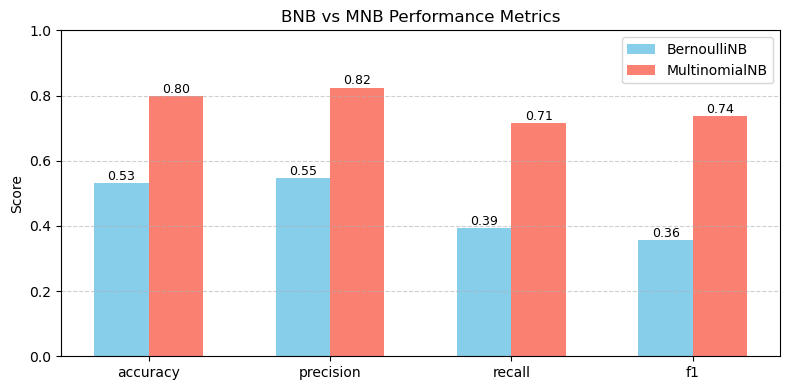

In [13]:
import numpy as np
import matplotlib.pyplot as plt


metrics = df_metrics.index.tolist()
bnb_values = df_metrics['BernoulliNB'].values
mnb_values = df_metrics['MultinomialNB'].values

x = np.arange(len(metrics))  
width=0.3

# Create plot for BNB and MNB across each metric
plt.figure(figsize=(8, 4))
plt.bar(x - width/2, bnb_values, width=0.3, label='BernoulliNB', color='skyblue')
plt.bar(x + width/2, mnb_values, width=0.3, label='MultinomialNB', color='salmon')

plt.ylabel('Score')
plt.title('BNB vs MNB Performance Metrics')
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

for i in range(len(metrics)):
    plt.text(x[i] - width/2, bnb_values[i] + 0.01, f'{bnb_values[i]:.2f}', ha='center', fontsize=9)
    plt.text(x[i] + width/2, mnb_values[i] + 0.01, f'{mnb_values[i]:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

#### 4. Varying Features
   On varying the feature sizes from 200 till 1500, it can be seen that for both BNB and MNB using the feature size of 500 provides the best scores for all metrics. From the graph we can conclude that for feature size of 500, the accuracy, precision, recall and f1-scores are all the highest. Thus the N value can be set to 500.
   

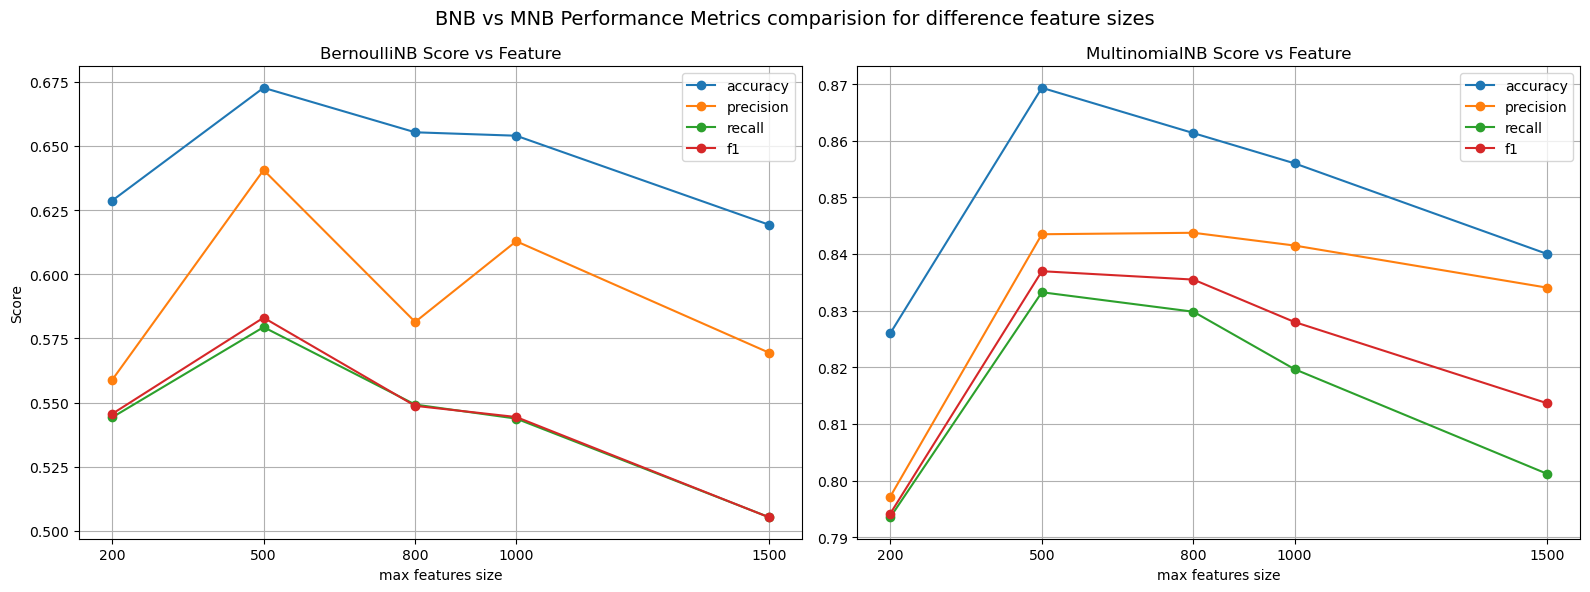

In [15]:

# Values of features to test
feature_sizes = [200, 500, 800, 1000, 1500]

# Store metric results for plotting
bnb_plot_data = {key: [] for key in score_metrics}
mnb_plot_data = {key: [] for key in score_metrics}

# Iterate through feature(word) sizes
for max_feat in feature_sizes:
    count_vectorizer = CountVectorizer(max_features=max_feat)

    # Create pipelines
    bnb_pipeline = make_pipeline(count_vectorizer, BernoulliNB())
    mnb_pipeline = make_pipeline(count_vectorizer, MultinomialNB())

    # Cross validation using K-Fold for metrics
    bnb_scores = cross_validate(bnb_pipeline, X, y, cv=kf, scoring=score_metrics)
    mnb_scores = cross_validate(mnb_pipeline, X, y, cv=kf, scoring=score_metrics)

    # Append mean metric scores for plotting
    for key in score_metrics:
        bnb_plot_data[key].append(bnb_scores['test_' + key].mean())
        mnb_plot_data[key].append(mnb_scores['test_' + key].mean())

# Plotting charts 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
metrics = list(score_metrics.keys())

# Plot for BNB showing metrics for difference feature sizes
for metric in metrics:
    axes[0].plot(feature_sizes, bnb_plot_data[metric], marker='o', label=metric)
axes[0].set_title("BernoulliNB Score vs Feature")
axes[0].set_xlabel("max features size")
axes[0].set_ylabel("Score")
axes[0].set_xticks(feature_sizes)
axes[0].legend()
axes[0].grid(True)

# Plot for MNB showing metrics for difference feature sizes
for metric in metrics:
    axes[1].plot(feature_sizes, mnb_plot_data[metric], marker='o', label=metric)
axes[1].set_title("MultinomialNB Score vs Feature")
axes[1].set_xlabel("max features size")
axes[1].set_xticks(feature_sizes)
axes[1].legend()
axes[1].grid(True)

plt.suptitle("BNB vs MNB Performance Metrics comparision for difference feature sizes", fontsize=14)
plt.tight_layout()
plt.show()


In [16]:
bnb_rows = []
mnb_rows = []
for i, n in enumerate(feature_sizes):
    bnb_row = {
        'number_of_features': n,
        'bnb_accuracy': bnb_plot_data['accuracy'][i],
        'bnb_precision': bnb_plot_data['precision'][i],
        'bnb_recall': bnb_plot_data['recall'][i],
        'bnb_f1': bnb_plot_data['f1'][i],        
    }
    mnb_row = {
        'number_of_features': n,
        'mnb_accuracy': mnb_plot_data['accuracy'][i],
        'mnb_precision': mnb_plot_data['precision'][i],
        'mnb_recall': mnb_plot_data['recall'][i],
        'mnb_f1': mnb_plot_data['f1'][i],
    }
    bnb_rows.append(bnb_row)
    mnb_rows.append(mnb_row)

df_bnb_feat = pd.DataFrame(bnb_rows)
df_mnb_feat = pd.DataFrame(mnb_rows)

print("Table showing the number of features vs Metrics for BNB\n")
print(df_bnb_feat)

print("\n\nTable showing the number of features vs Metrics for MNB\n")
print(df_mnb_feat)

Table showing the number of features vs Metrics for BNB

   number_of_features  bnb_accuracy  bnb_precision  bnb_recall    bnb_f1
0                 200      0.628667       0.558769    0.544224  0.545585
1                 500      0.672667       0.640628    0.579426  0.583106
2                 800      0.655333       0.581441    0.549251  0.548756
3                1000      0.654000       0.612891    0.543784  0.544403
4                1500      0.619333       0.569495    0.505400  0.505352


Table showing the number of features vs Metrics for MNB

   number_of_features  mnb_accuracy  mnb_precision  mnb_recall    mnb_f1
0                 200      0.826000       0.797170    0.793521  0.794167
1                 500      0.869333       0.843481    0.833241  0.836956
2                 800      0.861333       0.843740    0.829802  0.835477
3                1000      0.856000       0.841490    0.819667  0.827989
4                1500      0.840000       0.834052    0.801185  0.813647


#### 5. Machine Learning Method (SVM)
Since the text data vectorized with CountVectorizer or TF-IDF results in very high-dimensional feature spaces (many words/features), most of which are sparse (lots of zeros). This is best suited by SVM. SVM is designed to handle high-dimensional spaces efficiently, especially with a linear kernel (LinearSVC), by finding the optimal separating hyperplane maximizing the margin between classes. SVM also includes built-in regularization that helps it ignore noisy features and prevent overfitting. SVM finds a global decision boundary by maximizing the margin so it also generalizes well to unseen data. This means SVM can capture complex patterns in data especially when dealing with vectorizers.

To compare with other algorithms, KNN is also used. But here since KNN relies on distance metrics (usually Euclidean distance), it become less meaningful in high-dimensional sparse spaces as the distances between points tend to become very similar, making it harder to find truly “nearest” neighbors.

To further evaluate findings of the choosen ML algorithms with Naive Bayes, the metrics(accuracy, precision, etc.) is printed for each method and is used to compare the different models (i.e BNB, MNB, KNN, SVM). From the table it can be seen that SVM outperforms both BNB and MNB and has a high accuracy score. To achieve the best version of SVM, TFIDF vectorizer can be used along with SVM to further improve the model and overall score. On performing experiments with different methods and evaluating each method on accuracy scores we can conclude that using SVM with Tfidf (500 feautres) performs the best.

In [18]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
import warnings
warnings.filterwarnings('ignore')

# Define metrics
score_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro')
}


# Evaluating SVM with Count Vectorizer 
max_features = 500
vectorizer = CountVectorizer(max_features=max_features)
svm_clf = LinearSVC()
svm_pipeline = make_pipeline(vectorizer, svm_clf)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
svm_scores = cross_validate(svm_pipeline, X, y, cv=kf, scoring=score_metrics)
svm_results = {metric: svm_scores[f'test_{metric}'].mean() for metric in score_metrics.keys()}
print("LinearSVC + Count Vectorizer cross-validation results:")
for metric, score in svm_results.items():
    print(f"{metric}: {score:.4f}")


# Evaluating SVM with TFIDF Vectorizer 
tfidfvectorizer = TfidfVectorizer(max_features=500)
tfidf_svm_pipeline = make_pipeline(tfidfvectorizer, svm_clf)
tfidfsvm_scores = cross_validate(tfidf_svm_pipeline, X, y, cv=kf, scoring=score_metrics)
tfidfsvm_results = {metric: tfidfsvm_scores[f'test_{metric}'].mean() for metric in score_metrics.keys()}
print("\nLinearSVC + Tfidf cross-validation results:")
for metric, score in tfidfsvm_results.items():
    print(f"{metric}: {score:.4f}")
   

LinearSVC + Count Vectorizer cross-validation results:
accuracy: 0.8607
precision: 0.8217
recall: 0.8334
f1: 0.8255

LinearSVC + Tfidf cross-validation results:
accuracy: 0.9027
precision: 0.8895
recall: 0.8669
f1: 0.8754


In [19]:
# Evaluate KNN
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_pipeline = make_pipeline(vectorizer, knn_clf)

#  cross-validation
knn_scores = cross_validate(knn_pipeline, X, y, cv=kf, scoring=score_metrics)

knn_results = {metric: knn_scores[f'test_{metric}'].mean() for metric in score_metrics.keys()}

print("KNN cross-validation results:")
for metric, score in knn_results.items():
    print(f"{metric}: {score:.4f}")

KNN cross-validation results:
accuracy: 0.6173
precision: 0.6306
recall: 0.5841
f1: 0.5847


In [20]:
# Comparing results of Different Algorithms
df_metrics = pd.DataFrame({
    'BernoulliNB': bnb_scores_metrics,
    'MultinomialNB': mnb_scores_metrics,
    'KNN': knn_results,    
    'LinearSVC + CountVectorizer': svm_results,
    'LinearSVC + TfidfVectorizer': tfidfsvm_results,
}).round(4)

df_metrics

,BernoulliNB,MultinomialNB,KNN,LinearSVC + CountVectorizer,LinearSVC + TfidfVectorizer
accuracy,0.5320,0.7987,0.6173,0.8607,0.9027
precision,0.5456,0.8239,0.6306,0.8217,0.8895
recall,0.3928,0.7148,0.5841,0.8334,0.8669
f1,0.3566,0.7371,0.5847,0.8255,0.8754


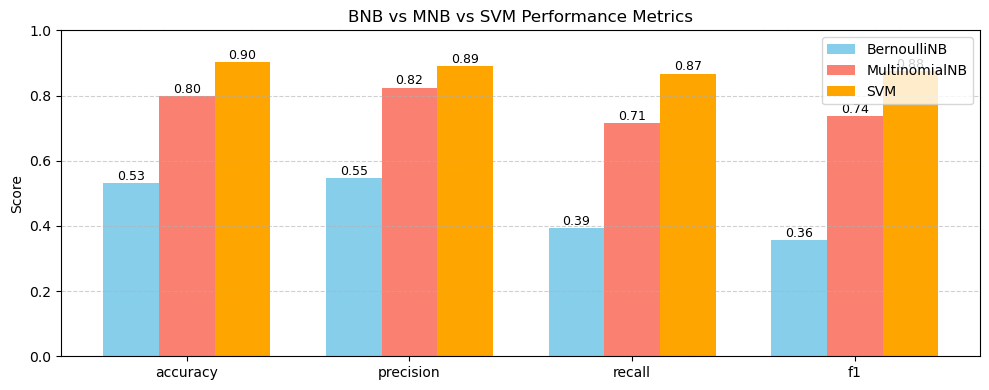

In [21]:
import numpy as np
import matplotlib.pyplot as plt


metrics = df_metrics.index.tolist()
bnb_values = df_metrics['BernoulliNB'].values
mnb_values = df_metrics['MultinomialNB'].values
svm_values = df_metrics['LinearSVC + TfidfVectorizer'].values

x = np.arange(len(metrics))  
width=0.25

# Create plot for BNB and MNB across each metric
plt.figure(figsize=(10, 4))
plt.bar(x - width, bnb_values, width=width, label='BernoulliNB', color='skyblue')
plt.bar(x, mnb_values, width=width, label='MultinomialNB', color='salmon')
plt.bar(x + width, svm_values, width=width, label='SVM', color='orange')

plt.ylabel('Score')
plt.title('BNB vs MNB vs SVM Performance Metrics')
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

for i in range(len(metrics)):
    plt.text(x[i] - width, bnb_values[i] + 0.01, f'{bnb_values[i]:.2f}', ha='center', fontsize=9)
    plt.text(x[i], mnb_values[i] + 0.01, f'{mnb_values[i]:.2f}', ha='center', fontsize=9)
    plt.text(x[i] + width, svm_values[i] + 0.01, f'{svm_values[i]:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

As can be seen from the above graphs, SVM with TfidfVectorizer(max_features=500) performs the best. 

## Part 2. Recommendation Methods

In [23]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Split dataset into Training (weeks 1-3) and Test (week 4)
train_df = df_dataset.iloc[:751].copy()   # Weeks 1–3
df_test =df_dataset.iloc[751:1001].copy()  # Week 4

# splitting the training set into topics
topic_groups = train_df.groupby('topic')

# Create tfidf vector for documents(songs lyrics) in each topic
topic_vectorizers = {}
topic_tfidf_matrices = {}
for topic, group in topic_groups:
    vectorizer = TfidfVectorizer(max_features=500) # Tfidf using the same settings as previously defined
    tfidf_matrix = vectorizer.fit_transform(group['lyrics'])
    topic_vectorizers[topic] = vectorizer
    topic_tfidf_matrices[topic] = tfidf_matrix
    print(f"Topic '{topic}': {tfidf_matrix.shape[0]} documents, {tfidf_matrix.shape[1]} features")


# Train a SVM classifier with settings as Part 1 on training set
vectorizer = TfidfVectorizer(max_features=500)
X_train = vectorizer.fit_transform(train_df['lyrics'])
y_train = train_df['topic']
svm_model = LinearSVC(random_state=42, max_iter=2000)
svm_model.fit(X_train, y_train)


# Predict topics for the training set
train_df['predicted_topic'] = svm_model.predict(X_train)

X_test = vectorizer.transform(df_test['lyrics'])
df_test['predicted_topic'] = svm_model.predict(X_test)

train_df.head()

Topic 'dark': 246 documents, 500 features
Topic 'emotion': 42 documents, 500 features
Topic 'lifestyle': 92 documents, 500 features
Topic 'personal': 188 documents, 500 features
Topic 'sadness': 183 documents, 500 features


,artist_name,track_name,release_date,genre,lyrics,topic,predicted_topic
0,loving,the not real lake,2016,rock,awak know see time clear world mirror world mi...,dark,dark
1,incubus,into the summer,2019,rock,summer pretti build spill readi overflow piss ...,lifestyle,lifestyle
2,reignwolf,hardcore,2016,blues,lose deep catch breath think say tri break wal...,sadness,sadness
3,tedeschi trucks band,anyhow,2016,blues,run bitter tast take rest feel anchor soul pla...,sadness,sadness
4,lukas nelson and promise of the real,if i started over,2017,blues,think think differ set apart sober mind sympat...,dark,dark


In [24]:
# Read User 1 file
df_user1 = pd.read_csv('user1.tsv', sep='\t')
df_user1

,topic,keywords
0,dark,"fire, enemy, pain, storm, fight"
1,sadness,"cry, alone, heartbroken, tears, regret"
2,personal,"dream, truth, life, growth, identity"
3,lifestyle,"party, city, night, light, rhythm"
4,emotion,"love, memory, hug, kiss, feel"


In [25]:
# Read User 2 file
df_user2 = pd.read_csv('user2.tsv', sep='\t')
df_user2

,topic,keywords
0,sadness,"lost, sorrow, goodbye, tears, silence"
1,emotion,"romance, touch, feeling, kiss, memory"


In [26]:
# Function to Build user profile from training data
def build_user_profile(train_df, df_user, topic_vectorizers):
    user_profiles = {}
    liked_topic_songs = {}
    keywords = []

    # Apply preprocess_text function defined in PArt 1
    df_user['keywords_preprocessed'] = df_user['keywords'].apply(preprocess_text) 

    # for topic in topic_vectorizers:
    for i, row in df_user.iterrows():
        topic = row['topic']
        keywords = []
        vectorizer = topic_vectorizers[topic]

        # Get preprocessed keywords for this topic row
        if not row.empty:
            keywords = row['keywords_preprocessed'].split()

        # Combine songs in the training set predicted to be in topic that user likes
        df_topic = train_df[train_df['predicted_topic'] == topic]
        df_user_liked_songs = df_topic[df_topic['lyrics'].apply(lambda x: any(word in x for word in keywords))]
        topic_document = " ".join(df_user_liked_songs['lyrics'])

        # Create vectorizer for user liked document(songs) in topic
        tfidf_vector = vectorizer.transform([topic_document])
        user_profiles[topic] = tfidf_vector
        liked_topic_songs[topic] = topic_document

    return user_profiles, liked_topic_songs


# Create profiles for user 1 and user 2
user1_profile, user_song_lyrics_liked = build_user_profile(train_df, df_user1, topic_vectorizers)
user2_profile, user_song_lyrics_liked = build_user_profile(train_df, df_user2, topic_vectorizers)



#### 1. 
The User profiles for User are build using the training data. Here to analyse the user liked songs, the keywords is used and based on the keywords the match the lyrics, the songs are selected as user liked songs. Further a vectorizer is created on these songs. This is done for each topic.

On analysing the dataset, the top 20 words printed for each User (1,2,3) are mostly within the topic(dark, lifestyle,etc) and appear to be Reasonable classified. The words for all the users mostly seem to be reasonable, and lie within the correct topic words. Overall the model is performing as expected. One thing to note is that since preprocessing is done on the words, the word stems(root words) are printed. 

Another observation is that there are few words that are generally neutral but are also being classified into a partifular topic. Certain words are also being classified into multiple topic. Eg. the word 'yeah' appears in the Top 20 keywords in topics dark and lifestyle, even though it is a neutral word. This shows that the model is unable to grasp the sentiment of the word. Further the words in the topic 'sadness' are also similar for User 1 and 2.

It can also be seen that there are a lot of common words present in the different user profiles for each topic. Words printed across the user profiles for each topic are nearly the same. This may be due the limited dataset. Since the same document set is used having the same vocabulary, the words in the document may have the same vectorizer and score on each run.

In [28]:

# Function to print Top N Words for a User 
def print_top_words(user_profiles, topic_vectorizers, top_n=20):
    for topic, profile_vector in user_profiles.items():
        vectorizer = topic_vectorizers[topic]
        feature_names = np.array(vectorizer.get_feature_names_out())

        # Retrieve top indices and words from vectorizer
        tfidf_array = profile_vector.toarray().flatten()
        top_indices = tfidf_array.argsort()[::-1][:top_n]
        top_words = feature_names[top_indices]

        print(f"Topic: {topic}")
        print(f"Top {top_n} words: {', '.join(top_words)}\n")
        
# Print top 20 words in each profile - These words appear to be reasonable and as expected for each topic
print("\nTop 20 words (words stem) in user 1 profile:\n")
print_top_words(user1_profile, topic_vectorizers, top_n=20)

print("\nTop 20 words (words stem) in user 2 profile:\n")
print_top_words(user2_profile, topic_vectorizers, top_n=20)


Top 20 words (words stem) in user 1 profile:

Topic: dark
Top 20 words: fight, like, grind, know, blood, stand, come, yeah, tell, gon, black, kill, hand, lanki, dilli, caus, peopl, time, good, head

Topic: sadness
Top 20 words: cri, tear, babi, break, woah, fall, heart, know, club, away, want, gon, feel, steal, think, wan, wish, hurt, place, right

Topic: personal
Top 20 words: life, live, chang, know, world, ordinari, yeah, dream, wan, thank, like, teach, lord, come, time, beat, think, thing, learn, need

Topic: lifestyle
Top 20 words: tonight, night, song, come, home, closer, time, sing, stranger, long, wait, wan, tire, spoil, right, struggl, yeah, mind, play, like

Topic: emotion
Top 20 words: good, touch, feel, hold, know, vision, video, loov, morn, vibe, feelin, want, miss, kiss, love, lovin, luck, gim, sunris, look


Top 20 words (words stem) in user 2 profile:

Topic: sadness
Top 20 words: tear, break, heart, away, cri, insid, babi, step, woah, fall, know, fade, gon, like, club

In [29]:
# Define a user 3 by choosing keywords from a range of topics, based on personal interest
user3 = {'topic':['dark','sadness','personal','lifestyle','emotion'],
         'keywords':["steal, angry, kill, death, jail, liars",
                     "sorry, pain, funeral, sick, mistake",
                     "house, life, people, memory, dream",
                     "country, dance, money, travel, song",
                     "good, love, kiss, tense, worry"]}

df_user3 = pd.DataFrame(user3)
df_user3     

,topic,keywords
0,dark,"steal, angry, kill, death, jail, liars"
1,sadness,"sorry, pain, funeral, sick, mistake"
2,personal,"house, life, people, memory, dream"
3,lifestyle,"country, dance, money, travel, song"
4,emotion,"good, love, kiss, tense, worry"


In [30]:
# Build user profile for User 3 using the training dataset
user3_profile, user3_song_lyrics_liked = build_user_profile(train_df, df_user3, topic_vectorizers)

# Print top 20 words in User 3 profile
print("\nTop 20 words (word stem) in user 3 profile:\n")
print_top_words(user3_profile, topic_vectorizers, top_n=20)


Top 20 words (word stem) in user 3 profile:

Topic: dark
Top 20 words: kill, death, blood, grind, dilli, lanki, head, list, like, know, feat, fight, steadi, feel, come, peopl, gladiat, time, slow, face

Topic: sadness
Top 20 words: fall, break, pain, heart, yeah, ohohoh, away, caus, know, hurt, gon, leav, babi, like, blame, sanctuari, time, think, feel, need

Topic: personal
Top 20 words: life, live, world, chang, thank, know, yeah, ordinari, wan, dream, good, like, time, think, teach, lord, believ, year, come, thing

Topic: lifestyle
Top 20 words: song, sing, wan, spoil, home, struggl, tire, countri, play, night, tonight, like, time, yeah, telephon, right, need, know, want, hallelujah

Topic: emotion
Top 20 words: good, feel, hand, hold, vision, darl, morn, luck, video, vibe, want, heart, feelin, know, kiss, come, yeah, love, lovin, sunris



#### 2. Evaluation
The recommender is created to sugges the top N recommendations based on the user profile. These recommendations show the top N songs in total.
Since a Top-N recommender is built, top-N metrics are used to evaluate the performance. 
    - Precision@N: This shows the proportion of top-N recommended songs that the user actually liked. This helps us analyse if our ssytem is showing useful songs
    - Recall@N: This shows us the liked songs when compared to all songs the user would have liked (in the test set) that are included in the top-N recommendations. Recall is chosen here to understand how well the system retrieves all relevant song information. The high recall shows us that most liked songs are not missed.
    - F1 Score@N: This is Harmonic mean of precision and recall. This is used as it helps to balance the trade-off between precision and recall, and also gives us a single score that reflects both accuracy and completeness of recommendations.
    - Hit Rate@N: This is used as it shows if at least one liked song appears in top-N recommendations based on user preferences. Hit rate is useful in determining how often users find something they like.

Choosing the Value of N:
The value of N is choosen as 10 as this gives a good trade-off between metrics scores to the right amount of songs displayed to user. Choosing a very large N (>50) lowers the accuracy, precision of the model. It also provides too many recommendation options to the user and it would be difficult for the user to review the large number of songs and provide feedback. Choosing an N value <5 results in overfitting and also provides very few options to the user. thus N=15 is choosen. This N shows N songs in total so that it provides a distributed range of songs to the user, which account for the top songs aligning to user interest.

Evaluation of Recommender on Metrics - The matching algorithm is analysed on the precision, recall, and other metrics on different parameters such as N, M, similarity scores. This is done to determine the best algorithm

In [32]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np
from scipy.sparse import issparse

# Function to calculate document similarity for information retrieval using different similarity scores
def similarity_scoring_func(user_vec, tfidf_matrix, similarity_algorithm):
    if similarity_algorithm == 'cosine': # Cosine Similarity
        return cosine_similarity(user_vec, tfidf_matrix).flatten()
        
    elif similarity_algorithm == 'jaccard': # Jaccard Similarity
        user_bin = (user_vec > 0).astype(int)
        doc_bin = (tfidf_matrix > 0).astype(int)

        if issparse(user_bin):
            user_bin = user_bin.toarray()
        if issparse(doc_bin):
            doc_bin = doc_bin.toarray()

        intersection = np.minimum(user_bin, doc_bin).sum(axis=1)
        union = np.maximum(user_bin, doc_bin).sum(axis=1)
        jaccard = intersection / (union)
        return jaccard

    elif similarity_algorithm == 'euclidean': # Euclidean Disatnce
        distances = euclidean_distances(user_vec, tfidf_matrix).flatten()
        similarity = 1 / (1 + distances)
        return similarity

# Recommend Top N songs based on user profile for N songs in Total
def recommend_top_n_songs(user_profile, df_test, topic_vectorizers, similarity_algorithm, n):
    all_recommendations = []

    for idx, row in df_test.iterrows():
        pred_topic = row['predicted_topic']
        lyrics = row['lyrics']

        # Skip topic if not present in user profile
        if pred_topic not in user_profile:
            continue

        user_vec = user_profile[pred_topic]
        vectorizer = topic_vectorizers[pred_topic]
        tfidf_vec = vectorizer.transform([lyrics])
        
        # Compute document similarity of topic vectorizer with user profile using similarity scorer such as cosine similarity   
        similarity_score = similarity_scoring_func(user_vec, tfidf_vec, similarity_algorithm)[0]

        row_copy = row.copy()
        row_copy['similarity_score'] = similarity_score
        all_recommendations.append(row_copy)

    # Create a DataFrame of all scored songs
    scored_df = pd.DataFrame(all_recommendations)

    # Select the top N songs having highest similarity score
    top_n_df = scored_df.sort_values(by='similarity_score', ascending=False).head(n).reset_index(drop=True)

    return top_n_df


# Function to restrict the words(features) in user profile to M
def user_profile_with_M(user_profile, topic_vectorizers, M):
    new_user_profile_m = {}
    
    for topic, user_vec in user_profile.items():
        vectorizer = topic_vectorizers[topic]
        arr = user_vec.toarray().flatten()
        
        # Get indices of M words 
        top_indices = np.argsort(arr)[::-1][:M]
        
        # Create a new vector with only M words
        new_vec = np.zeros_like(arr)
        new_vec[top_indices] = arr[top_indices]
        
        # create reshaped 2D vector of user profile with M words
        new_user_profile_m[topic] = new_vec.reshape(1, -1)
    
    return new_user_profile_m
    



In [33]:
# View Top N songs recommeded to user 1 using Cosine similarity score
# When comparing with Jaccard and Euclidean distance (shown below) the Cosine similarity has the highest scores (similarity_score) for each song.
recommend_top_n_songs(user1_profile, df_test, topic_vectorizers, similarity_algorithm='cosine',n=10)


,artist_name,track_name,release_date,genre,lyrics,topic,predicted_topic,similarity_score
0,timeflies,once in a while,2016,pop,think know better wish think think pressur wis...,emotion,emotion,0.607976
1,justin moore,got it good,2016,country,wake morn warn littl bounc blue eye start pill...,emotion,emotion,0.585448
2,taylor swift,i did something bad,2017,pop,trust narcissist play like violin look ohsoeas...,emotion,emotion,0.535392
3,dirty heads,horsefly,2019,reggae,say life live know thing passion sound real ad...,emotion,emotion,0.492612
4,the band steele,sit awhile,2017,country,wake favorit place studio hide space cold dark...,personal,personal,0.429615
5,thomas rhett,life changes,2017,country,wakin colleg dorm yeah life pretti normal look...,personal,personal,0.404648
6,anita baker,will you be mine,2017,jazz,come feel explain lose break heart come mend a...,sadness,sadness,0.401828
7,anita baker,you're the best thing yet,2017,jazz,best thing come life understand hand world cal...,personal,personal,0.395365
8,ty segall,alta,2018,blues,want know feel green want see sailor come figh...,personal,personal,0.387750
9,kehlani,feels,2019,pop,real contempl bout feel hard think true want m...,emotion,emotion,0.372498


In [34]:
# View Top N songs recommeded to user 1 using Jaccard similarity score
# As seen from the similarity score column in table, Jaccard scores are very low
recommend_top_n_songs(user1_profile, df_test, topic_vectorizers, similarity_algorithm='jaccard',n=10)

,artist_name,track_name,release_date,genre,lyrics,topic,predicted_topic,similarity_score
0,deca,donner bell,2019,jazz,donner readi tabl live watchin star fall like ...,dark,dark,0.133188
1,soja,i can't stop dreaming,2017,reggae,wide awak move head question room leav littl c...,sadness,sadness,0.123656
2,lil wayne,scared of the dark (feat. xxxtentacion),2018,pop,scar dark run run run afraid fall scar afraid ...,dark,sadness,0.118598
3,alborosie,rocky road,2016,reggae,road road road road life cycl time wast life r...,personal,personal,0.117155
4,mike love,forgiveness,2016,reggae,tell hide eye wonder embrac face know walk sho...,personal,personal,0.104603
5,the dear hunter,the revival,2016,jazz,take littl longer hop know take villag rais sc...,sadness,sadness,0.101064
6,alec benjamin,boy in the bubble,2018,pop,walk home step gate chicken plate food cold co...,dark,dark,0.100218
7,hunter hayes,still,2019,country,soul worri okay stay time break count star yea...,dark,dark,0.098253
8,timeflies,once in a while,2016,pop,think know better wish think think pressur wis...,emotion,emotion,0.095355
9,post malone,blame it on me,2018,pop,free peopl wan takin piec away need hold drown...,sadness,sadness,0.093583


In [35]:
# View Top N songs recommeded to user 1 using Euclidean similarity score 
# Euclidean scores for each song is better than the Jaccard score
recommend_top_n_songs(user1_profile, df_test, topic_vectorizers, similarity_algorithm='euclidean',n=10)

,artist_name,track_name,release_date,genre,lyrics,topic,predicted_topic,similarity_score
0,timeflies,once in a while,2016,pop,think know better wish think think pressur wis...,emotion,emotion,0.530373
1,justin moore,got it good,2016,country,wake morn warn littl bounc blue eye start pill...,emotion,emotion,0.523409
2,taylor swift,i did something bad,2017,pop,trust narcissist play like violin look ohsoeas...,emotion,emotion,0.509176
3,dirty heads,horsefly,2019,reggae,say life live know thing passion sound real ad...,emotion,emotion,0.498167
4,the band steele,sit awhile,2017,country,wake favorit place studio hide space cold dark...,personal,personal,0.483543
5,thomas rhett,life changes,2017,country,wakin colleg dorm yeah life pretti normal look...,personal,personal,0.478196
6,anita baker,will you be mine,2017,jazz,come feel explain lose break heart come mend a...,sadness,sadness,0.477606
7,anita baker,you're the best thing yet,2017,jazz,best thing come life understand hand world cal...,personal,personal,0.476266
8,ty segall,alta,2018,blues,want know feel green want see sailor come figh...,personal,personal,0.474705
9,kehlani,feels,2019,pop,real contempl bout feel hard think true want m...,emotion,emotion,0.471638


In [36]:
# Function to evaluate recommendtations
def evaluate_recommendation(user_profile, df_user, df_test, topic_vectorizers, similarity_algorithm, n, M=None ):
    # If M is set get user profile restricted to M words
    if M is not None:
        user_profile = user_profile_with_M(user_profile, topic_vectorizers, M)
        
    df_recommended_songs = recommend_top_n_songs(user_profile, df_test, topic_vectorizers, similarity_algorithm, n)
    
    eval_scores = []
    total_relevant_songs = 0

    for idx, row in df_recommended_songs.iterrows():
        pred_topic = row['predicted_topic']
        lyrics = row['lyrics']

        # Check matching topic for keywords showing actual liked songs
        user_topic_row = df_user[df_user['topic'] == pred_topic]
        if user_topic_row.empty:
            actual_liked = 0
            continue

        # Match user interests to find actual liked songs which will be used to calculate metrics
        keywords = user_topic_row['keywords_preprocessed'].values[0].split()
        actual_liked = int(any(word in lyrics for word in keywords))
        if any(word in lyrics for word in keywords):
            total_relevant_songs += 1
        
        eval_scores.append(actual_liked)   

    # Calculate metrics
    eval_scores = np.array(eval_scores)
    precision = np.sum(eval_scores) / len(eval_scores) if len(eval_scores) > 0 else 0
    recall = np.sum(eval_scores) / total_relevant_songs if total_relevant_songs > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    accuracy = np.mean(eval_scores)
    hit_rate = int(np.any(eval_scores))

    return {
        'accuracy': accuracy,
        'precision@N': precision,
        'recall@N': recall,
        'f1@N': f1,
        'hit_rate@N': hit_rate,
    }




In [37]:
# Evaluation of recommender when N words are recommended
# On analysing the performance of the recommender for different values of N, it can be seen that the recommender performs better for lower number of N for all Users. 
# This may be due to the fact that the recommender has to provide few songs that has the highest score. To ensure that ample songs are provided to the user as well for review , N=10 is taken.

N = [5, 10, 15, 20, 50] 
metrics_result = {}

print("\nTable Evaluating Recommender on Top N Recommendations for User 1\n")
for n in N:
    result = evaluate_recommendation(user1_profile, df_user1, df_test, topic_vectorizers, 'cosine', n=n)
    metrics_result[n] = result

df_N_analysis = pd.DataFrame(metrics_result).T 
df_N_analysis.index.name = 'N'
print(df_N_analysis)


print("\n\nTable Evaluating Recommender on Top N Recommendations for User 2\n")
for n in N:
    result = evaluate_recommendation(user2_profile, df_user2, df_test, topic_vectorizers, 'cosine', n=n)
    metrics_result[n] = result

df_N_analysis2 = pd.DataFrame(metrics_result).T 
df_N_analysis2.index.name = 'N'
print(df_N_analysis2)


print("\n\nTable Evaluating Recommender on Top N Recommendations for User 3\n")
for n in N:
    result = evaluate_recommendation(user3_profile, df_user3, df_test, topic_vectorizers, 'cosine', n=n)
    metrics_result[n] = result

df_N_analysis3 = pd.DataFrame(metrics_result).T
df_N_analysis3.index.name = 'N'
print(df_N_analysis3)


Table Evaluating Recommender on Top N Recommendations for User 1

    accuracy  precision@N  recall@N      f1@N  hit_rate@N
N                                                        
5       1.00         1.00       1.0  1.000000         1.0
10      1.00         1.00       1.0  1.000000         1.0
15      1.00         1.00       1.0  1.000000         1.0
20      0.95         0.95       1.0  0.974359         1.0
50      0.76         0.76       1.0  0.863636         1.0


Table Evaluating Recommender on Top N Recommendations for User 2

    accuracy  precision@N  recall@N      f1@N  hit_rate@N
N                                                        
5   1.000000     1.000000       1.0  1.000000         1.0
10  0.800000     0.800000       1.0  0.888889         1.0
15  0.666667     0.666667       1.0  0.800000         1.0
20  0.650000     0.650000       1.0  0.787879         1.0
50  0.400000     0.400000       1.0  0.571429         1.0


Table Evaluating Recommender on Top N Recommendatio

In [109]:
# Evaluation of recommender when different values of M (number of words in user profile) are taken
# On analysing the values of M for each User, we can see that it is consitent and it does not directly affect accuracy and other metrics. 
# For few Users it can be seen that as M values increases, the accuracy, precision etc also increase suggesting better performance of the recommender.
# However this is not always the case. To ensure the model performs well in case larger vocabulary and for all users, a value of M such as 50 can be taken.

M = [10, 15, 20, 50, 100, 150] 
metrics_result = {}

print("\nTable Evaluating Recommender on M words for User 1\n")
for m in M:
    result = evaluate_recommendation(user1_profile, df_user1, df_test, topic_vectorizers, 'cosine', n=10, M=m)
    metrics_result[m] = result

df_M_analysis = pd.DataFrame(metrics_result).T  # Transpose so M values are rows
df_M_analysis.index.name = 'M'
print(df_M_analysis)


print("\n\nTable Evaluating Recommender on M words for User 2\n")
for m in M:
    result = evaluate_recommendation(user2_profile, df_user2, df_test, topic_vectorizers, 'cosine', n=10, M=m)
    metrics_result[m] = result

df_M_analysis2 = pd.DataFrame(metrics_result).T  # Transpose so M values are rows
df_M_analysis2.index.name = 'M'
print(df_M_analysis2)


print("\n\nTable Evaluating Recommender on M words for User 3\n")
for m in M:
    result = evaluate_recommendation(user3_profile, df_user3, df_test, topic_vectorizers, 'cosine', n=10, M=m)
    metrics_result[m] = result

df_M_analysis3 = pd.DataFrame(metrics_result).T  # Transpose so M values are rows
df_M_analysis3.index.name = 'M'
print(df_M_analysis3)


Table Evaluating Recommender on M words for User 1

     accuracy  precision@N  recall@N  f1@N  hit_rate@N
M                                                     
10        1.0          1.0       1.0   1.0         1.0
15        1.0          1.0       1.0   1.0         1.0
20        1.0          1.0       1.0   1.0         1.0
50        1.0          1.0       1.0   1.0         1.0
100       1.0          1.0       1.0   1.0         1.0
150       1.0          1.0       1.0   1.0         1.0


Table Evaluating Recommender on M words for User 2

     accuracy  precision@N  recall@N      f1@N  hit_rate@N
M                                                         
10        0.7          0.7       1.0  0.823529         1.0
15        0.7          0.7       1.0  0.823529         1.0
20        0.7          0.7       1.0  0.823529         1.0
50        0.7          0.7       1.0  0.823529         1.0
100       0.7          0.7       1.0  0.823529         1.0
150       0.7          0.7       1.0  0.

In [39]:
# Evaluate Recommender for each user for similarity scores (cosine, jaccard, euclidean)
# Overall it can be seen that the model performs the best for Cosine similarity. Although the values of Cosine and Euclidean are nearly the same here, on looking at the above tables with similarity_score, we can see that the 
# cosine similarity provides a higher score for individual songs as compared to Euclidean. Jaccard performs poorly when compared to these two. 
# Thus cosine similarity provides the best results and can be used for the model.

# Define similarity algorithms to test
similarity_algorithms = ['cosine', 'jaccard', 'euclidean']
metrics_result = {}

print("\nTable Evaluating Recommender on different Document Similarity Algorithms for User 1\n")
for sim in similarity_algorithms:
    result = evaluate_recommendation(user1_profile, df_user1, df_test, topic_vectorizers, sim, n=15)
    metrics_result[sim] = result
df_similarity = pd.DataFrame(metrics_result).T
print(df_similarity)

print("\n\nTable Evaluating Recommender on different Document Similarity Algorithms for User 2\n")
for sim in similarity_algorithms:
    result = evaluate_recommendation(user2_profile, df_user2, df_test, topic_vectorizers, sim, n=15)
    metrics_result[sim] = result
df_similarity2 = pd.DataFrame(metrics_result).T
print(df_similarity2)


print("\n\nTable Evaluating Recommender on different Document Similarity Algorithms for User 3\n")
for sim in similarity_algorithms:
    result = evaluate_recommendation(user3_profile, df_user3, df_test, topic_vectorizers, sim, n=15)
    metrics_result[sim] = result
df_similarity3 = pd.DataFrame(metrics_result).T
print(df_similarity3)


Table Evaluating Recommender on different Document Similarity Algorithms for User 1

           accuracy  precision@N  recall@N      f1@N  hit_rate@N
cosine          1.0          1.0       1.0  1.000000         1.0
jaccard         0.8          0.8       1.0  0.888889         1.0
euclidean       1.0          1.0       1.0  1.000000         1.0


Table Evaluating Recommender on different Document Similarity Algorithms for User 2

           accuracy  precision@N  recall@N  f1@N  hit_rate@N
cosine     0.666667     0.666667       1.0  0.80         1.0
jaccard    0.600000     0.600000       1.0  0.75         1.0
euclidean  0.666667     0.666667       1.0  0.80         1.0


Table Evaluating Recommender on different Document Similarity Algorithms for User 3

           accuracy  precision@N  recall@N      f1@N  hit_rate@N
cosine     0.866667     0.866667       1.0  0.928571         1.0
jaccard    0.466667     0.466667       1.0  0.636364         1.0
euclidean  0.866667     0.866667       1.

Based on the Above Analysis, we can determine that the algorithm performs the best when the value of N=10, M=100, similarity=Cosine.

Overall this is consistent for all users and these metrics may provide the best matching algorithm.

## PART 3 - User Evaluation

In [42]:
import random
N=10 # Obtained from Part 2
seed=42
random.seed(seed)

# Create week-wise batches for the dataset
df_week1 = df_dataset.iloc[:251].copy()
df_week2 = df_dataset.iloc[251:501].copy()
df_week3 = df_dataset.iloc[501:751].copy()
# Note: df_test previously created in Part 1 has week 4 data


In [43]:
# N Random songs for Week 1 
df1 = df_week1.sample(N, random_state=seed)
df1

,artist_name,track_name,release_date,genre,lyrics,topic
155,buczer,hip hop prod. crackhouse,2017,hip hop,ghost porcelain wast innoc transluc eye shift ...,dark
6,rebelution,trap door,2018,reggae,long long road occur look shortcut wan caus sc...,dark
164,green day,boulevard of broken dreams,2017,pop,walk lone road know know home walk walk street...,sadness
60,phish,we are come to outlive our brains,2018,blues,overlap futur pass pass vapor light liquid blu...,dark
113,chase rice,whisper,2016,country,roll dial right minor chord steer night slide ...,dark
182,cody johnson,billy's brother,2016,country,bull fight lead gon fight gon fight brother fe...,dark
198,guts,peaceful life,2016,jazz,danger start futil think server law conceiv fa...,dark
248,the struts,kiss this,2016,rock,say stay home away say good make stori keep se...,emotion
9,eli young band,never land,2017,country,word yeah wreck roll lip high good get bottl r...,sadness
118,h.e.r.,hard place,2018,pop,mmhmm mmhmm wan believ hate day test yeah know...,sadness


In [44]:
# Based on my interaction with the user, the user has liked the following songs for Week 1. Dataframe is created on songs liked by user.
df_userweek1 = df1.iloc[[2, 6, 7, 8, 9]].copy()
df_userweek1

,artist_name,track_name,release_date,genre,lyrics,topic
164,green day,boulevard of broken dreams,2017,pop,walk lone road know know home walk walk street...,sadness
198,guts,peaceful life,2016,jazz,danger start futil think server law conceiv fa...,dark
248,the struts,kiss this,2016,rock,say stay home away say good make stori keep se...,emotion
9,eli young band,never land,2017,country,word yeah wreck roll lip high good get bottl r...,sadness
118,h.e.r.,hard place,2018,pop,mmhmm mmhmm wan believ hate day test yeah know...,sadness


In [45]:
# N Random songs for Week 2
df2 = df_week2.sample(N, random_state=seed)
df2

,artist_name,track_name,release_date,genre,lyrics,topic
393,white denim,good news,2018,blues,good news long time stay long telephon telepho...,lifestyle
257,black rebel motorcycle club,haunt,2018,blues,apart flame wear face rap like scarecrow wing ...,sadness
348,white denim,there's a brain in my head,2016,blues,atwo aon child guess gon turn wild take look p...,dark
311,wrabel,poetry,2017,rock,summer learn number like rememb septemb drive ...,personal
363,mandisa,bleed the same,2017,rock,bleed beauti come bleed tell tell divid wake t...,dark
432,mitch rossell,ask me how i know,2019,country,stubborn come settl stick rule way got freedom...,sadness
448,sufjan stevens,visions of gideon,2017,rock,love time video video touch time video video l...,emotion
435,louis armstrong,life is so peculiar,2016,jazz,life peculiar write burkejimmi heusen note mar...,personal
260,radiohead,daydreaming,2016,rock,dreamer learn learn point return return late l...,personal
355,el michels affair,tearz,2017,jazz,laughter come tear laughter come tear laughter...,sadness


In [46]:
# Based on my interaction with the user, the user has liked the following songs in Week 2. Dataframe is created on songs liked by user
df_userweek2 = df2.iloc[[2, 3, 7, 8, 9]].copy()
df_userweek2

,artist_name,track_name,release_date,genre,lyrics,topic
348,white denim,there's a brain in my head,2016,blues,atwo aon child guess gon turn wild take look p...,dark
311,wrabel,poetry,2017,rock,summer learn number like rememb septemb drive ...,personal
435,louis armstrong,life is so peculiar,2016,jazz,life peculiar write burkejimmi heusen note mar...,personal
260,radiohead,daydreaming,2016,rock,dreamer learn learn point return return late l...,personal
355,el michels affair,tearz,2017,jazz,laughter come tear laughter come tear laughter...,sadness


In [47]:
# N Random songs for Week 3
df3 = df_week3.sample(N, random_state=seed)
df3

,artist_name,track_name,release_date,genre,lyrics,topic
643,the score,the fear,2019,rock,whoaohoh whoaohoh whoaohoh whoaohoh whoaohoh w...,dark
507,leon bridges,there she goes,2016,blues,move fast like train somebodi babe babi lie le...,emotion
598,chase rice,on tonight,2017,country,littl dress hang hanger wear feel danger slip ...,lifestyle
561,midland,at least you cried,2017,country,word lip sound good right thing like heart bre...,sadness
613,shenseea,tie me up,2018,reggae,shenseea oouuuu oouuuu oouuu oouuu strangl via...,dark
682,camila cabello,havana,2017,pop,havana half heart havana take east nanana hear...,sadness
698,nappy roots,headz up,2018,hip hop,head silli head shawti head head shawti head k...,dark
685,sabrina carpenter,thumbs,2016,pop,world father mother father mother mother daugh...,personal
510,the stooges,till the end of the night,2017,blues,wait station rememb think late stand quiet lik...,personal
605,blues saraceno,the dark horse always wins,2018,blues,deliv evil deliv deliv deliv evil yeah deliv o...,dark


In [48]:
# Based on my interaction with the user, the user has liked the following songs in Week 3. Dataframe is created on songs liked by user.
df_userweek3 = df3.iloc[[1, 3, 4, 5,6]].copy()
df_userweek3

,artist_name,track_name,release_date,genre,lyrics,topic
507,leon bridges,there she goes,2016,blues,move fast like train somebodi babe babi lie le...,emotion
561,midland,at least you cried,2017,country,word lip sound good right thing like heart bre...,sadness
613,shenseea,tie me up,2018,reggae,shenseea oouuuu oouuuu oouuu oouuu strangl via...,dark
682,camila cabello,havana,2017,pop,havana half heart havana take east nanana hear...,sadness
698,nappy roots,headz up,2018,hip hop,head silli head shawti head head shawti head k...,dark


In [49]:
# Create the training data for user profile from the songs the user liked (Week 1-3)
df_user_train = pd.concat([df_userweek1, df_userweek2, df_userweek3], ignore_index=True)

# Apply same preprocessing used in part 1 
df_user_train['lyrics'] = df_user_train['lyrics'].apply(preprocess_text) 
df_user_train

,artist_name,track_name,release_date,genre,lyrics,topic
0,green day,boulevard of broken dreams,2017,pop,walk lone road know know home walk walk street...,sadness
1,guts,peaceful life,2016,jazz,danger start futil think server law conceiv fa...,dark
2,the struts,kiss this,2016,rock,say stay home away say good make stori keep se...,emotion
3,eli young band,never land,2017,country,word yeah wreck roll lip high good get bottl r...,sadness
4,h.e.r.,hard place,2018,pop,mmhmm mmhmm wan believ hate day test yeah know...,sadness
5,white denim,there's a brain in my head,2016,blues,atwo aon child guess gon turn wild take look p...,dark
6,wrabel,poetry,2017,rock,summer learn number like rememb septemb drive ...,personal
7,louis armstrong,life is so peculiar,2016,jazz,life peculiar write burkejimmi heusen note mar...,personal
8,radiohead,daydreaming,2016,rock,dreamer learn learn point return return late l...,personal
9,el michels affair,tearz,2017,jazz,laughter come tear laughter come tear laughter...,sadness


In [50]:
# Create keywords indicating user liked songs for user profile.
# Group by predicted_topic and combine lyrics for each topic
df_user_train_profile = df_user_train.groupby('topic')['lyrics'].apply(lambda x: ' '.join(x)).reset_index()
df_user_train_profile.rename(columns={'lyrics': 'keywords'}, inplace=True)
df_user_train_profile

,topic,keywords
0,dark,danger start futil think server law conceiv fa...
1,emotion,say stay home away say good make stori keep se...
2,personal,summer learn number like rememb septemb drive ...
3,sadness,walk lone road know know home walk walk street...


In [51]:
# Using Same Approach as Part 2 to create the User Profile and Recommender
real_user_profile, real_user_song_lyrics_liked = build_user_profile(train_df, df_user_train_profile, topic_vectorizers)
print("\nTop 20 words in user profile:\n")
print_top_words(real_user_profile, topic_vectorizers, top_n=20)


Top 20 words in user profile:

Topic: dark
Top 20 words: stand, come, like, know, head, blood, fight, black, gon, hand, feel, tell, kill, evil, yeah, time, grind, caus, wan, look

Topic: emotion
Top 20 words: good, hold, feel, hand, touch, know, lip, want, vision, darl, morn, heart, luck, video, loov, yeah, come, vibe, feelin, miss

Topic: personal
Top 20 words: life, live, chang, world, thank, yeah, know, day, believ, good, time, like, teach, want, need, wan, give, promis, reason, think

Topic: sadness
Top 20 words: fall, break, heart, away, leav, like, know, come, yeah, think, insid, feel, gon, wan, caus, time, babi, walk, hurt, want



In [52]:
# Using Same approach as Part 2, train the recommender on the user profile and recommend top N(10) songs on the Week 4 (df_test)
user_profile = user_profile_with_M(real_user_profile, topic_vectorizers, M=100)

# Top N songs recommended
df_recommended = recommend_top_n_songs(user_profile, df_test, topic_vectorizers, similarity_algorithm='cosine',n=N)
df_recommended

,artist_name,track_name,release_date,genre,lyrics,topic,predicted_topic,similarity_score
0,timeflies,once in a while,2016,pop,think know better wish think think pressur wis...,emotion,emotion,0.561599
1,justin moore,got it good,2016,country,wake morn warn littl bounc blue eye start pill...,emotion,emotion,0.553033
2,taylor swift,i did something bad,2017,pop,trust narcissist play like violin look ohsoeas...,emotion,emotion,0.501493
3,dirty heads,horsefly,2019,reggae,say life live know thing passion sound real ad...,emotion,emotion,0.454027
4,randy houser,our hearts (feat. lucie silvas),2019,country,hand wrong folk think fall hard heart know nig...,sadness,sadness,0.430952
5,thomas rhett,life changes,2017,country,wakin colleg dorm yeah life pretti normal look...,personal,personal,0.414078
6,anita baker,no one in the world,2017,jazz,look good time share blind think better come s...,personal,personal,0.398586
7,hellyeah,love falls,2016,rock,cri sleep felt incomplet deep bleed feel want ...,sadness,sadness,0.396714
8,keith urban,the fighter,2016,country,know hurt scar scar deserv caus preciou heart ...,sadness,sadness,0.396587
9,the band steele,sit awhile,2017,country,wake favorit place studio hide space cold dark...,personal,personal,0.394653


In [111]:
# Evaluation Based on User Feedback
# Based on the user interaction, the user has liked 5 songs from week 4 songs as shown in the table below, 1 of which is a part of the recommended N songs.
df_liked = pd.concat([df_recommended.iloc[[2]].copy(), df_test.iloc[[12, 19, 24, 30]]].copy(), ignore_index=True)
df_liked

,artist_name,track_name,release_date,genre,lyrics,topic,predicted_topic,similarity_score
0,taylor swift,i did something bad,2017,pop,trust narcissist play like violin look ohsoeas...,emotion,emotion,0.501493
1,jason isbell and the 400 unit,white man's world,2017,country,white live white world roof babi girl think wo...,dark,dark,NaN
2,dirty heads,horsefly,2019,reggae,say life live know thing passion sound real ad...,emotion,emotion,NaN
3,marcus miller,7-t's,2018,jazz,right super fair minut right super fair minut ...,lifestyle,lifestyle,NaN
4,lester nowhere,balcony,2017,jazz,leav away biggest babi leav away heart babi gi...,sadness,sadness,NaN


In [54]:
# Evaluting the Recommendations based on the user liked songs and recommended songs in Week 4
def evaluate_recommendation_from_user_feedback(df_liked, df_recommended, top_n=N):

    # Using 'track_name' column to match songs
    liked_set = set(df_liked['track_name'])
    recommended_set = set(df_recommended['track_name'])

    # True Positives
    true_positive = liked_set & recommended_set

    # Calculate Metrics
    accuracy = len(true_positive) / (len(df_liked) + len(df_recommended) - len(true_positive)) 
    precision = len(true_positive) / len(df_recommended) 
    recall = len(true_positive) / len(df_liked)
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0

    hit_rate = 1 if len(true_positive) > 0 else 0

    return {
        'Accuracy': accuracy,
        'Precision@N': precision,
        'Recall@N': recall,
        'F1@N': f1,
        'HitRate@N': hit_rate
    }

user_feedback_metrics = evaluate_recommendation_from_user_feedback(df_liked, df_recommended, top_n=N)
df_metrics = pd.DataFrame([user_feedback_metrics], index=['User'])  # Use real user name/index if needed
print(df_metrics)

      Accuracy  Precision@N  Recall@N      F1@N  HitRate@N
User  0.153846          0.2       0.4  0.266667          1


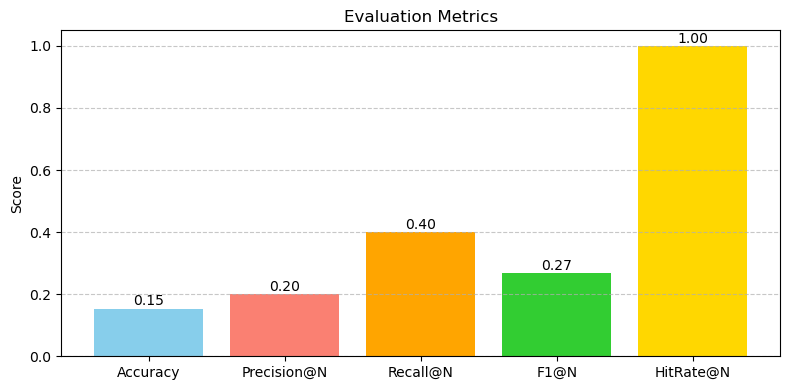

In [55]:
# Create plot of metrics obtained from user study
labels = list(user_feedback_metrics.keys())
values = list(user_feedback_metrics.values())

plt.figure(figsize=(8, 4))
bars = plt.bar(labels, values, color=['skyblue', 'salmon', 'orange','limegreen', 'gold'])

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', fontsize=10)

plt.title('Evaluation Metrics')
plt.ylim(0, 1.05)
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### Metrics
    - The same Top-N Metric as Part 2 are used in this task since the same Top N Recommender system is used. Here Results are available for all metrics (Accuracy, Precision, Recall, F1, and even HitRate). 
    - When comparing this with the Part 2 metrics, the values of metrics are lower for the real user. This is because the real user is not restricted by keywords and may choose any song from Week 4 that may not have a matching keyword as in the user profile built. Due to this it is hard to find many matches. This results in a low accuracy, precision, recall and F1 score. 
    - In Part 2 the Recall was often 1 which indicates it was able to get matches, however here the recall is is very low. Similarly the lower precision and F1 score as well indicate that the model is unable to recommend songs which are liked by the real user.
    - Only the HitRate remains 1 in both cases, this is because the recommender was able to find at least 1 match here. But in most cases when we used the recommender for real user, the hit rate was also often 0.

#### User Feedback:
    - The quality of the recommender is not good. The recommender system is not able to take the users likings into consideration. It only gets 1 song correct. 
    - After trying the recommender multiple times and selecting similar songs based on keywords/lyrics of previously liked songs (Week1-3), the recommender was able to get hits on 1 songs.
    - The recommender system performs well for hypothetical users but fails to perform for real users. This is because a user may like a song that does not have any relevant keywords in the topic. 
    - The recommender system created overfits in Part 2 for the hypothetical users, and it fails to perfrom well for Real user. This suggests that keywords based matching is not ideal when building content based recommender systems.
    - The recommender is not able to grasp the users preferences as it is restricted to the limited vocabulary, keywords and Top N words.